# Hecatomb viral analysis

This is an analysis of the viral data from the CF MGI sequence libraries. We are exploring different viral components.

Notes on validating a sequence match.

We need to do two things to validate any "spurious" matches in the database. First, we need to check the database sequence to ensure that it is correct. There is a [blacklist](

You will need to use `mmseqs` to extract the secondary AA database to fasta:

```
mmseqs convert2fasta databases/aa/virus_secondary_aa/sequenceDB secondary_aa.faa
```

1. Check the protein sequence in the database

```
grep -A 1 <protein id> secondary_aa.faa
```

BLAST that sequence at NCBI and make sure it is what the header says it is.

2. Find the DNA sequence in the seqtable.fasta.gz

```
zgrep -A1 <DNA ID> seqtable.fasta.gz
```

BLAST that sequence at NCBI and see if it matches the same sequence

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.api as sms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Read the data

In [2]:
if not os.path.exists('bigtable.tsv.gz'):
    print(f"No bigtable in {os.getcwd()}. Trying to change location")
    os.chdir('GitHubs/CF_Data_Analysis/hecatomb')
os.listdir()

In [3]:
metadata = pd.read_csv('CF_Metadata_Table-2023-03-23.tsv.gz',compression='gzip',header=0,sep='\t')
vmr = pd.read_csv('VMR_MSL39_v1.ascii.tsv.gz', compression='gzip',header=0,sep='\t')

There are multiple entries for Family and sometimes they have different entries for host source. This just keeps the first one.

In [4]:
vmrfh = vmr[['Family', 'Host source']].drop_duplicates(subset='Family', keep='first')

In this analysis, I am _only_ using `aa` hits, because the `nt` hits are often spurious and I'm skeptical about them.

We just filter out `aa` hits, and start by looking at different viral families that are found in our samples.

In [5]:
# the blacklist is some dodgy sequences that we need to filter out.
blacklist = ['A0A097ZRK1', 'G0W2I5', 'F1AXJ9', 'Q8QTC0']

In [6]:
data = pd.read_csv('bigtable.tsv.gz',compression='gzip',header=0,sep='\t')

In [7]:
# choose only the amino acid sequences
virusesFiltered = data[(data.alnType == "aa") & (data.kingdom == "Viruses") & (~data.targetID.isin(blacklist) & (data.evalue < 1e-20))]

In [8]:
# create new columns for the patient and the sample date
virusesFiltered[['patient', 'date', 'Sputum or BAL']] = virusesFiltered['sampleID'].str.split('_', expand=True)

### Add the domain and then filter the viruses for now!

This data comes from the [VMR](https://ictv.global/vmr) so its not that great! The `host source` could be a host or it could be a source, or it could be both!

We end up with:
    'bacteria', 'algae', 'vertebrates', 'protists', 'archaea',
    'invertebrates', 'plants', 'fungi', 'invertebrates, vertebrates',
    'plants (S)'

The `plants (S)` means the sample was taken from a plant.

In [9]:
virusesFiltHost = pd.merge(virusesFiltered, vmrfh, left_on="family", right_on="Family", how='left')
really_bacterial = ['unclassified Caudoviricetes family', 'unclassified Crassvirales family']
virusesFiltHost.loc[(virusesFiltHost['family'].isin(really_bacterial)), 'Host source'] = 'bacteria'
to_remove = []

#### A quick look at some of these families

#### Bacteria

There are plenty of bacterial viruses (duh!) so we make that its own dataframe and filter them out from virusesFiltered

In [10]:
bacterial_viruses = virusesFiltHost[(virusesFiltHost['Host source'] == 'bacteria')]
to_remove.append('bacteria')

#### Archaea

In [11]:
host_source = "archaea"
rds = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].shape[0]
sps = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].species.unique()
fams = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].family.unique()
print(f"There are {rds} reads that map to {host_source} viruses, and they belong to {len(sps)} species ", end="")
if len(sps) < 5:
    spsstr = "; ".join(sps)
    print(f"({spsstr}) ", end="")
print(f"and {len(fams)} families: {fams}")
to_remove.append(host_source)

#### Plants

There are not really enough plant related sequences (there are 736 total) to make any meaningful comparisons, so we will ignore those.

In [12]:
host_source = "plants"
rds = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].shape[0]
sps = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].species.unique()
fams = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].family.unique()
print(f"There are {rds} reads that map to {host_source} viruses, and they belong to {len(sps)} species ", end="")
if len(sps) < 5:
    spsstr = "; ".join(sps)
    print(f"({spsstr}) ", end="")
print(f"and {len(fams)} families: {fams}")
to_remove.append(host_source)

In [13]:
host_source = "plants (S)"
rds = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].shape[0]
sps = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].species.unique()
fams = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].family.unique()
print(f"There are {rds} reads that map to {host_source} viruses, and they belong to {len(sps)} species ", end="")
if len(sps) < 5:
    spsstr = "; ".join(sps)
    print(f"({spsstr}) ", end="")
print(f"and {len(fams)} families: {fams}")
to_remove.append(host_source)

#### Algae

There are quite a few algal viruses but they are all members of the Phycodnaviridae.

In [14]:
host_source = "algae"
rds = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].shape[0]
sps = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].species.unique()
fams = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].family.unique()
print(f"There are {rds} reads that map to {host_source} viruses, and they belong to {len(sps)} species ", end="")
if len(sps) < 5:
    spsstr = "; ".join(sps)
    print(f"({spsstr}) ", end="")
print(f"and {len(fams)} families: {fams}")
to_remove.append(host_source)

#### Protists

In [15]:
host_source = "protists"
rds = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].shape[0]
sps = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].species.unique()
fams = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].family.unique()
print(f"There are {rds} reads that map to {host_source} viruses, and they belong to {len(sps)} species ", end="")
if len(sps) < 5:
    spsstr = "; ".join(sps)
    print(f"({spsstr}) ", end="")
print(f"and {len(fams)} families: {fams}")

I'm not sure about these. I have included them for now, because somne of those families (Metaviridae) include LTR retrotransposons from Eukaryotes.

#### Invertebrates

In [16]:
host_source = "invertebrates"
rds = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].shape[0]
sps = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].species.unique()
fams = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].family.unique()
print(f"There are {rds} reads that map to {host_source} viruses, and they belong to {len(sps)} species ", end="")
if len(sps) < 5:
    spsstr = "; ".join(sps)
    print(f"({spsstr}) ", end="")
print(f"and {len(fams)} families: {fams}")

I don't think we should remove these - I think they may also infect euks

#### Fungi

In [17]:
host_source = "fungi"
rds = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].shape[0]
sps = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].species.unique()
fams = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].family.unique()
print(f"There are {rds} reads that map to {host_source} viruses, and they belong to {len(sps)} species ", end="")
if len(sps) < 5:
    spsstr = "; ".join(sps)
    print(f"({spsstr}) ", end="")
print(f"and {len(fams)} families: {fams}")

Hmm, odd that the metaviridae are represented here too, since I did the join on viral family. Ho hum, we'll keep these, too.

### Filter out the unwanted viruses

In [18]:
virusesFiltHost = virusesFiltHost[~virusesFiltHost['Host source'].isin(to_remove)]
virusesFiltHost['Host source'].unique()

### What do we have after filtering?

In [19]:
#filter
virusesGroup = virusesFiltHost.groupby(by=['family','alnlen','pident'], as_index=False).count()

#styling
sizeScatter = 10 * virusesGroup['count']
sns.set_style("darkgrid")
sns.set_palette("colorblind")
sns.set(rc={'figure.figsize':(20,10)})

g = sns.FacetGrid(virusesGroup, col="family", col_wrap=6)
g.map_dataframe(sns.scatterplot, "alnlen", "pident", alpha=.8, sizes=(100,500), size=sizeScatter)
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelleft=True, labelbottom=True)
    ax.axhline(y=80, c='red', linestyle='dashed', label="_horizontal")
    ax.axvline(x=150, c='red', linestyle='dashed', label="_vertical")

g.fig.subplots_adjust(hspace=0.4)
g.set_axis_labels("Alignment length", "Percent Identity")
plt.legend(bbox_to_anchor=(5.0,1), loc=0, borderaxespad=2,ncol=6, shadow=True, labelspacing=1.5, borderpad=1.5)
plt.savefig("img/EukViruses.png")
plt.show()


In [20]:
virusesFiltHost.family.unique()

### Retroviridae

There are lots of hits to Lentivirus, especially HIV-1, which we know are spurious. Here, we filter those out. These are hits to `G0W2I5` and `A0A097ZRK1`. (Note, I am keeping a list of sequences that are incorrect in `sequence_ids.yaml` and those are included in the `blacklist` list above. Here we just look at other Retroviridae.

We note that these are hERVs and we only find them in a few samples, as we might expect.

In [21]:
virusesFiltHost[virusesFiltHost.family == 'Retroviridae']

In [22]:
virusesFiltHost[virusesFiltHost.family == 'Retroviridae'].patient.unique()

### Parvoviridae

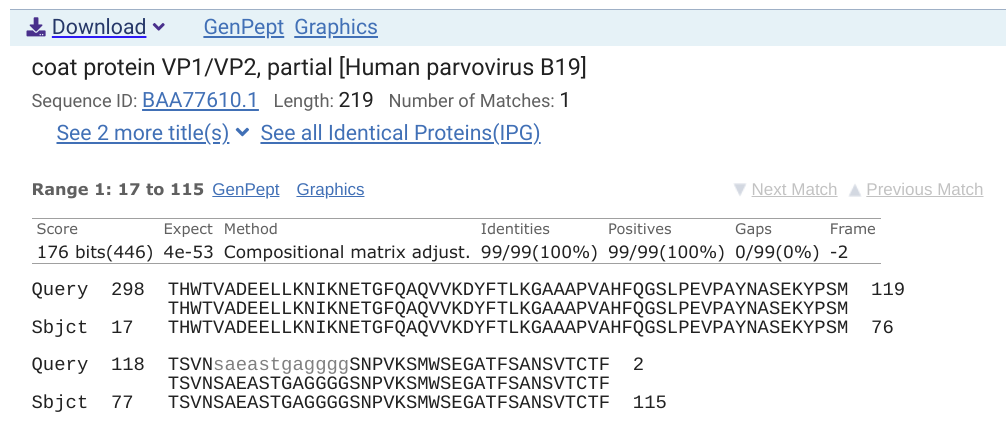There is a single sequence from patient 788707 that maps to the human Parovirus. The sequence is

```
>788707_20171213_S:1:6.877e-03:2971
AAAATGTACAAGTTACAGAGTTGGCACTAAAAGTGGCCCCCTCACTCCACATGCTTTTAACAGGATTACTGCCCCCCCCTCCTGCACCAGTGCTGGCTTCTGCAGAATTAACTGAAGTCATGCTTGGGTATTTTTCTGAGGCGTTGTAAGCGGGAACTTCCGGCAAACTTCCTTGAAAATGGGCCACAGGGGCAGCTGCACCTTTTAAAGTAAAGTAGTCTTTTACTACTTGTGCTTGAAACCCAGTTTCATTTTTTATATTTTTTAAAAGCTCTTCATCTGCTACAGTCCAATGAGTA
```

The alignment using blastx is:

![Blastx alignment](img/human_parvo.png "Alignment of the above sequence to the NR using blastx")

In [23]:
virusesFiltHost[virusesFiltHost.family == 'Parvoviridae']

In [24]:
sorted(virusesFiltHost[virusesFiltHost.patient == '788707'].date.unique())

Note that for this patient it was the first sample, and we have not detected it in subsequent samples.

### Polyomaviridae

It looks like two patients (in different years) had polyomavirus. A0A2S1LV97 is MC Polyomavirus, while B3FQQ5 is WU or betapolyomavirus

In [25]:
virusesFiltHost[virusesFiltHost.family == 'Polyomaviridae']

In [25]:
virusesFiltHost[(virusesFiltHost.patient == '748699') | (virusesFiltHost.patient == '676138')][['patient', 'date']].drop_duplicates().sort_values(by = ['patient', 'date'])

Note that for patient 676138 this was the last sample taken, but for patient 748699 we took another sample 5 days later where we did not detect polyomavirus

### Adenoviridae

See the NOTE below. These are NOT Adenoviridae sequences

In [26]:
data[data.family == 'Adenoviridae'].alnType.unique()

all the hits to Adenoviruses are nt hits and there are no aa hits. This seems wrong!

Lets go dumpster diving and find out more about the Adenoviridae!

In [27]:
# choose only the amino acid sequences
adeno = data[(data.family == 'Adenoviridae') & (~data.targetID.isin(blacklist))]
adeno[['patient', 'date', 'Sputum or BAL']] = adeno['sampleID'].str.split('_', expand=True)

In [28]:
print(f"There are {len(adeno.seqID.unique())} adenovirus sequences that appear in {len(adeno.patient.unique())} patients")

In [29]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(x="tstart", data=adeno, bins=range(0, 35935, 50))
plt.tight_layout()
# Shink current axis by 50% to allow legend to fit nicely
ax = plt.gca()
box = ax.get_position()
ax.set_xlim(0, 35935)
ax.set_xlabel("Start position in genome")
ax.set_ylabel("Number of matches")
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), borderaxespad=1,ncol=1, shadow=True, labelspacing=1.5, borderpad=1.5)
plt.show()

Overall, there are very few matches (49 adenovirus sequences that appear in 24 patients), they are all nucleotide matches, and those are quite skewed to two regions of the genome (~2,000 bp in and about 32,000 bp in). My guess is that this region is conserved with another region in the human genome. 



In [30]:
adeno.head()

**NOTE**: These sequences are not even Adenovirus anyway. The first sequence matches to a Neiserria. Ignore all the Adenovirus hits.

### Herpes viruses

Who has them and what do they have?

In [34]:

witherpes = virusesFiltHost[virusesFiltHost.family == 'Herpesviridae'].patient.unique().shape[0]
herpessamps = virusesFiltHost[virusesFiltHost.family == 'Herpesviridae'].sampleID.unique().shape[0]

totalp = virusesFiltHost.patient.unique().shape[0]
print(f"{herpessamps} samples from {witherpes} pwCF out of {totalp} pwCF have Herpes viruses. Remember, some samples will appear multiple times because they are different matches to the herpes virus genome!")

In [35]:
herpes = virusesFiltHost[virusesFiltHost.family == 'Herpesviridae']

In [36]:
herpes.species

In [37]:
herpes.loc[:, 'renamed_species'] = herpes.species
herpes.loc[:,'renamed_species'] = herpes['renamed_species'].apply(lambda x: ' '.join(x.split(' ')[1:] if 'unclassified' not in x else x.split(' ')))
herpes['renamed_species']

In [38]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(pd.crosstab([herpes.patient], [sorted(herpes.renamed_species)], values=herpes['count'], aggfunc='sum', dropna=False).fillna(0),
            cmap="rocket_r")
plt.xlabel("")
plt.ylabel("pwCF ID")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("img/HerpesViruses.png")
plt.show()

### hERV data

What are the hERVs and who has them!

It turns out only six samples have hERV data, and these are all single reads. So they are there, but are they important for this study?

In [39]:
virusesFiltHost[virusesFiltHost.family == 'Retroviridae']

In [40]:
virusesFiltHost[virusesFiltHost.family == 'Retroviridae'].patient.unique().shape

### Papillomaviridae

Here, we extract the Papillomaviridae, and then ask are there more reads in M vs F. So we need to merge it with the metadata Gender column

**EXCEPT!:** Only two of our samples have Papillomaviridae, one from a female has very high levels, while the other, from a male, has very low levels.

In [42]:
papv = virusesFiltHost[virusesFiltHost.family == 'Papillomaviridae']
papvg = pd.merge(papv, metadata[['unique_ID', 'Gender']], left_on='sampleID', right_on='unique_ID')
papvg.head(5)

In [43]:
withpap = papvg.patient.unique().shape[0]
papvgsamps = papvg.sampleID.unique().shape[0]

totalp = virusesFiltered.patient.unique().shape[0]
print(f"{papvgsamps} samples from {withpap} pwCF out of {totalp} pwCF have Herpes viruses. Remember, some samples will appear multiple times because they are different matches to the herpes virus genome!")

In [44]:
papvg[['patient', 'date', 'Gender', 'genus']]

In [45]:
virusesFiltHost[(virusesFiltHost.patient == '670829') | (virusesFiltHost.patient == '753522')][['patient', 'date']].drop_duplicates().sort_values(by = ['patient', 'date'])

# Bacterial Viruses

In [46]:
bacterial_viruses

In [47]:
#filter
virusesGroup = bacterial_viruses.groupby(by=['family','alnlen','pident'], as_index=False).count()

#styling
sizeScatter = 10 * virusesGroup['count']
sns.set_style("darkgrid")
sns.set_palette("colorblind")
sns.set(rc={'figure.figsize':(20,10)})

g = sns.FacetGrid(virusesGroup, col="family", col_wrap=6)
g.map_dataframe(sns.scatterplot, "alnlen", "pident", alpha=.8, sizes=(100,500), size=sizeScatter)
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelleft=True, labelbottom=True)
    ax.axhline(y=80, c='red', linestyle='dashed', label="_horizontal")
    ax.axvline(x=150, c='red', linestyle='dashed', label="_vertical")

g.fig.subplots_adjust(hspace=0.4)
g.set_axis_labels("Alignment length", "Percent Identity")
plt.legend(bbox_to_anchor=(5.0,1), loc=0, borderaxespad=2,ncol=6, shadow=True, labelspacing=1.5, borderpad=1.5)
plt.savefig("img/Phages.png")
plt.show()


In [45]:
#filter for only viruses with more than 100 abundance total
virusesGroup = bacterial_viruses.groupby(by=['family','alnlen','pident'], as_index=False).count()
tokeep = virusesGroup.groupby('family')['count'].sum()
svg = virusesGroup[virusesGroup['family'].isin(tokeep[tokeep > 20].index)]

#styling
sizeScatter = 10 * svg['count']
sns.set_style("darkgrid")
sns.set_palette("colorblind")
sns.set(rc={'figure.figsize':(20,10)})

g = sns.FacetGrid(svg, col="family", col_wrap=6)
g.map_dataframe(sns.scatterplot, "alnlen", "pident", alpha=.8, sizes=(100,500), size=sizeScatter)
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelleft=True, labelbottom=True)
    ax.axhline(y=80, c='red', linestyle='dashed', label="_horizontal")
    ax.axvline(x=150, c='red', linestyle='dashed', label="_vertical")

g.fig.subplots_adjust(hspace=0.4)
g.set_axis_labels("Alignment length", "Percent Identity")
plt.legend(bbox_to_anchor=(5.0,1), loc=0, borderaxespad=2,ncol=6, shadow=True, labelspacing=1.5, borderpad=1.5)
plt.savefig("img/abundant_phages.png")
plt.show()